# Main objective
To recommend a food business restaurant by location and to show where the main competitors are.

## How it works
This recommender uses offer, demand, satisfaction and trends to calculate a score.

* Offer <-- Inegi
* Demand <-- Google Trends
* Satisfaction <-- Yelp
* Trends <-- Google Trends Interest Over Time

#### Score = Demand + Trends - Offer - Satisfaction
Biggest score is the recommendation.

# Main libraries

In [1]:
from dotenv import load_dotenv
load_dotenv()

import os
import pandas as pd

# Inegi
In this section we are getting the offer.

We are using an Inegi database from https://inegi.org.mx/app/descarga/default.html

Currently, we are using a preprocessed database from an attached notebook.

In [2]:
def prepareInegi():
    inegi = pd.read_csv('inegi.csv')
    inegi.drop(columns=['nom_estab', 'per_ocu', 'fecha_alta', 'nom_processed', 'tipoUniEco', 'localidad'], inplace=True)
    return inegi

In [3]:
inegi = prepareInegi()
inegi.entidad.value_counts()

VERACRUZ DE IGNACIO DE LA LLAVE             48459
YUCATAN                                     17180
SAN LUIS POTOSÍ                             15655
TAMAULIPAS                                  15576
SINALOA                                     15321
SONORA                                      13198
QUERÉTARO                                   12448
TABASCO                                     11959
QUINTANA ROO                                11275
ZACATECAS                                    8474
TLAXCALA                                     8267
Name: entidad, dtype: int64

## Filtering by state and city

In [4]:
def getInegiByState(state):
    return inegi[inegi['entidad']==state]

### As use case for the demonstration we are selecting TAMAULIPAS

In [5]:
sinegi = getInegiByState('YUCATAN')
sinegi.head()

,entidad,municipio,latitud,longitud,tipo,Cocina Económica,Antojitos,Pizza,Hamburguesas,Hot Dogs,...,Yucateca,Tabasqueña,Arrachera,Pastor,Birria,Barbacoa,Carnero,Pozole,Enchiladas,Chilaquiles
152158,YUCATAN,Mérida,21.001433,-89.605708,['arracher'],0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
152159,YUCATAN,Mérida,21.038795,-89.601918,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152160,YUCATAN,Mérida,21.024276,-89.624382,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152161,YUCATAN,Mérida,21.020646,-89.585322,['restaur'],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152162,YUCATAN,Mérida,20.998787,-89.566374,['pizz'],0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
sinegi['municipio'].value_counts()

Mérida          7710
Valladolid       667
Progreso         666
Tizimín          657
Kanasín          601
                ... 
Cuncunul           7
Quintana Roo       7
Chikindzonot       7
Yobaín             5
Chankom            5
Name: municipio, Length: 106, dtype: int64

In [7]:
def inegiFilterByMunicipio(municipio, df):
    return df.drop(df[df['municipio']!=municipio].index)

### As use case we are selecting Tampico as the city

In [8]:
sinegi = inegiFilterByMunicipio('Mérida', sinegi)
sinegi.head()

,entidad,municipio,latitud,longitud,tipo,Cocina Económica,Antojitos,Pizza,Hamburguesas,Hot Dogs,...,Yucateca,Tabasqueña,Arrachera,Pastor,Birria,Barbacoa,Carnero,Pozole,Enchiladas,Chilaquiles
152158,YUCATAN,Mérida,21.001433,-89.605708,['arracher'],0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
152159,YUCATAN,Mérida,21.038795,-89.601918,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152160,YUCATAN,Mérida,21.024276,-89.624382,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152161,YUCATAN,Mérida,21.020646,-89.585322,['restaur'],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152162,YUCATAN,Mérida,20.998787,-89.566374,['pizz'],0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Obtaining offer by food type

In [9]:
foods = ['Cocina Económica', 'Antojitos', 'Pizza', 'Hamburguesas', 'Hot Dogs', 'Sushi', 'Tamales', 'Mariscos', 
         'Pescado', 'Tacos', 'Carne', 'Asada', 'Panuchos', 'Cochinita', 'Pollo', 'Desayunos', 'Tortas', 'Mondongo', 
         'Menudo', 'Memelas', 'Empanadas', 'Chicharrón', 'Gorditas', 'Costillas', 'Carnitas', 'Doraditas', 
         'Baguettes', 'Parrilla', 'Huaraches', 'Rosticería', 'China', 'Yucateca', 'Tabasqueña', 'Arrachera', 
         'Pastor', 'Birria', 'Barbacoa', 'Carnero', 'Pozole', 'Enchiladas', 'Chilaquiles']

In [10]:
def getInegiResults(df):
    results = {}

    for food in foods:
        results[food] = df[food].sum()

    return results

In [11]:
inegi_results = getInegiResults(sinegi)
inegi_results

{'Cocina Económica': 1445,
 'Antojitos': 1086,
 'Pizza': 323,
 'Hamburguesas': 154,
 'Hot Dogs': 37,
 'Sushi': 42,
 'Tamales': 93,
 'Mariscos': 63,
 'Pescado': 96,
 'Tacos': 681,
 'Carne': 1,
 'Asada': 188,
 'Panuchos': 220,
 'Cochinita': 123,
 'Pollo': 240,
 'Desayunos': 93,
 'Tortas': 211,
 'Mondongo': 14,
 'Menudo': 0,
 'Memelas': 0,
 'Empanadas': 30,
 'Chicharrón': 79,
 'Gorditas': 10,
 'Costillas': 16,
 'Carnitas': 42,
 'Doraditas': 24,
 'Baguettes': 6,
 'Parrilla': 45,
 'Huaraches': 7,
 'Rosticería': 20,
 'China': 0,
 'Yucateca': 49,
 'Tabasqueña': 13,
 'Arrachera': 4,
 'Pastor': 22,
 'Birria': 0,
 'Barbacoa': 15,
 'Carnero': 1,
 'Pozole': 12,
 'Enchiladas': 1,
 'Chilaquiles': 0}

## Adding offer to the main dataframe df

In [12]:
def getInegiDfResult(inegi_results):
    return pd.DataFrame(inegi_results.items(), columns = ['Index', 'InegiCount']).set_index('Index')

In [13]:
df = getInegiDfResult(inegi_results)
df.head()

,InegiCount
Index,
Cocina Económica,1445
Antojitos,1086
Pizza,323
Hamburguesas,154
Hot Dogs,37


# Google Trends
In this section we are getting the demand.

We are using the Google Trends endpoint https://trends.google.com/trends by means of the Pytrends API https://pypi.org/project/pytrends/


We check the trending of each food type in Mexico. Google trends gives information by state.

In [14]:
from pytrends.request import TrendReq

In [15]:
def getGoogleTrends(df):
    pytrends = TrendReq(hl='es-MX', tz=360)
    
    resultados = []
    for comida in foods:
        print(comida)
        pytrends.build_payload([comida], cat=71, geo='MX', gprop='')
        resultados.append(pytrends.interest_by_region(resolution='REGION', inc_low_vol=True, inc_geo_code=False))
    return resultados

In [16]:
google_trends = getGoogleTrends(sinegi)
google_trends

Cocina Económica
Antojitos
Pizza
Hamburguesas
Hot Dogs
Sushi
Tamales
Mariscos
Pescado
Tacos
Carne
Asada
Panuchos
Cochinita
Pollo
Desayunos
Tortas
Mondongo
Menudo
Memelas
Empanadas
Chicharrón
Gorditas
Costillas
Carnitas
Doraditas
Baguettes
Parrilla
Huaraches
Rosticería
China
Yucateca
Tabasqueña
Arrachera
Pastor
Birria
Barbacoa
Carnero
Pozole
Enchiladas
Chilaquiles


[                      Cocina Económica
 geoName                               
 Aguascalientes                       0
 Baja California                      0
 Baja California Sur                  0
 Campeche                             0
 Chiapas                              0
 Chihuahua                            0
 Ciudad de México                    21
 Coahuila de Zaragoza                 0
 Colima                               0
 Durango                              0
 Estado de México                    29
 Guanajuato                           0
 Guerrero                             0
 Hidalgo                              0
 Jalisco                              0
 Michoacán                            0
 Morelos                              0
 Nayarit                              0
 Nuevo León                           0
 Oaxaca                               0
 Puebla                               0
 Querétaro                            0
 Quintana Roo                         0


### Filtering by state

In [17]:
def getTrends(google_trends, state):
    requests = google_trends[0].join(google_trends[1:]).T
    return requests[state].sort_values(ascending=False)

In [18]:
trends =  getTrends(google_trends, 'Yucatán')
trends

Cocina Económica    100
Parrilla            100
Pizza               100
Carnero             100
Panuchos            100
Doraditas           100
Yucateca            100
Baguettes           100
Pastor               99
Pollo                81
Cochinita            80
Chilaquiles          78
Mondongo             77
Desayunos            75
Chicharrón           72
Carne                68
Pescado              54
China                52
Tamales              52
Costillas            51
Hamburguesas         51
Arrachera            45
Carnitas             44
Enchiladas           41
Antojitos            39
Asada                37
Empanadas            37
Memelas              36
Huaraches            34
Barbacoa             31
Mariscos             31
Hot Dogs             31
Sushi                30
Pozole               24
Tortas               22
Tacos                21
Gorditas             18
Birria               14
Menudo               13
Tabasqueña           12
Rosticería            0
Name: Yucatán, d

## Adding demand to the main dataframe df

In [19]:
df['GoogleTrend'] = trends
df

,InegiCount,GoogleTrend
Index,,
Cocina Económica,1445,100
Antojitos,1086,39
Pizza,323,100
Hamburguesas,154,51
Hot Dogs,37,31
Sushi,42,30
Tamales,93,52
Mariscos,63,31
Pescado,96,54


## Interest over time

In [20]:
def getGoogleIOT():
    pytrends = TrendReq(hl='es-MX', tz=360)
    iot = {}
    for comida in foods:
        print(comida)
        pytrends.build_payload([comida], cat=71, geo='MX', gprop='')
        iot[comida] = pytrends.interest_over_time()
        
    return iot

In [21]:
iot = getGoogleIOT()
iot

Cocina Económica
Antojitos
Pizza
Hamburguesas
Hot Dogs
Sushi
Tamales
Mariscos
Pescado
Tacos
Carne
Asada
Panuchos
Cochinita
Pollo
Desayunos
Tortas
Mondongo
Menudo
Memelas
Empanadas
Chicharrón
Gorditas
Costillas
Carnitas
Doraditas
Baguettes
Parrilla
Huaraches
Rosticería
China
Yucateca
Tabasqueña
Arrachera
Pastor
Birria
Barbacoa
Carnero
Pozole
Enchiladas
Chilaquiles


{'Cocina Económica':             Cocina Económica isPartial
 date                                  
 2015-03-08                 0     False
 2015-03-15                 0     False
 2015-03-22                 0     False
 2015-03-29                65     False
 2015-04-05                 0     False
 ...                      ...       ...
 2020-02-02                 0     False
 2020-02-09                39     False
 2020-02-16                56     False
 2020-02-23                37     False
 2020-03-01                87      True
 
 [261 rows x 2 columns], 'Antojitos':             Antojitos isPartial
 date                           
 2015-03-08         24     False
 2015-03-15         20     False
 2015-03-22         24     False
 2015-03-29         12     False
 2015-04-05         16     False
 ...               ...       ...
 2020-02-02         38     False
 2020-02-09         32     False
 2020-02-16         35     False
 2020-02-23         35     False
 2020-03-01         31   

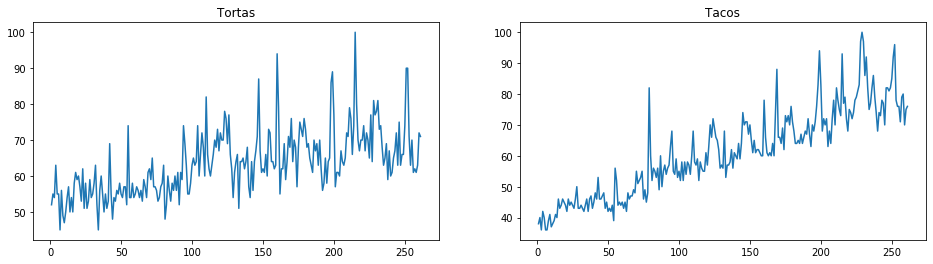

In [22]:
import matplotlib.pyplot as plt

x = [i+1 for i in range(len(iot['Tortas']['Tortas']))]

#for food in foods:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.title('Tortas')
plt.plot(x, iot['Tortas']['Tortas'].values);

plt.subplot(1,2,2)
plt.title('Tacos')
plt.plot(x, iot['Tacos']['Tacos'].values);

In [23]:
import numpy as np
from sklearn.linear_model import LinearRegression

def getTrendSlope(foods, iot):
    x = [i+1 for i in range(len(iot['Desayunos']['Desayunos']))]
    linreg = LinearRegression()

    slope = {}
    for food in foods:
        linreg.fit(np.array(x).reshape(-1,1), iot[food][food].values)
        slope[food] = linreg.coef_[0]

    return slope

In [24]:
slope = getTrendSlope(foods, iot)
slope

{'Cocina Económica': 0.0893514487618199,
 'Antojitos': 0.07222683432212255,
 'Pizza': 0.10346042480814792,
 'Hamburguesas': 0.04957039976782014,
 'Hot Dogs': 0.09922989180688577,
 'Sushi': 0.15124627938526333,
 'Tamales': 0.02539872166089592,
 'Mariscos': 0.1040867704726615,
 'Pescado': 0.019324248621432092,
 'Tacos': 0.1694420259042528,
 'Carne': 0.09041448154372606,
 'Asada': 0.053028124810172717,
 'Panuchos': 0.11827201490270721,
 'Cochinita': 0.03740862980136474,
 'Pollo': 0.07639459776864359,
 'Desayunos': 0.08225511436882849,
 'Tortas': 0.07333711300544678,
 'Mondongo': 0.06763858235298088,
 'Menudo': 0.06336620298189131,
 'Memelas': 0.11605753200909821,
 'Empanadas': -0.004676669298938318,
 'Chicharrón': 0.18861103799245418,
 'Gorditas': 0.08829584033585086,
 'Costillas': 0.02110676898779032,
 'Carnitas': 0.17017433737623264,
 'Doraditas': 0.07667064882121474,
 'Baguettes': -0.03145834598848552,
 'Parrilla': 0.12930663264961767,
 'Huaraches': 0.12403264016846538,
 'Rosticería': 

Tortas slope: 0.07333711300544678
Tacos slope: 0.1694420259042528


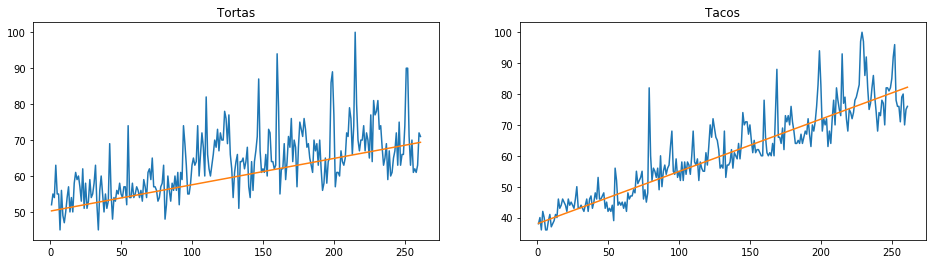

In [25]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.plot(x, iot['Tortas']['Tortas'].values);
plt.title('Tortas')

print('Tortas slope:',slope['Tortas'])
yslope = [50.3 + i*slope['Tortas'] for i in range(len(iot['Tortas']['Tortas']))]
plt.plot(x, yslope);

plt.subplot(1,2,2)
plt.plot(x, iot['Tacos']['Tacos'].values);
plt.title('Tacos')

print('Tacos slope:',slope['Tacos'])
yslope = [38.145240200412616 + i*slope['Tacos'] for i in range(len(iot['Tacos']['Tacos']))]
plt.plot(x, yslope);

## Adding trending to the main dataframe df

In [26]:
def addSlopeToDf(df):
    df['slope'] = ''
    for key in slope:
        df['slope'].loc[key] = slope[key]
    df.slope = df.slope.astype('float64')
    
    return df

In [27]:
df = addSlopeToDf(df)
df.head()

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,InegiCount,GoogleTrend,slope
Index,,,
Cocina Económica,1445,100,0.089351
Antojitos,1086,39,0.072227
Pizza,323,100,0.103460
Hamburguesas,154,51,0.049570
Hot Dogs,37,31,0.099230


# User location geocode with GeoPy

In [28]:
from geopy.geocoders import Nominatim
#user_input = input('Introduce lugar:')

def userLocationGeocoding(string):
    geolocator = Nominatim(user_agent="food-business-recommender")
    return geolocator.geocode(string)

In [29]:
location = userLocationGeocoding('Pensiones Mérida Yucatán')
location

Location(Parque Pensiones, Konoha, Mérida, Yucatán, México, (20.99759415, -89.64709420877386, 0.0))

In [30]:
location.longitude

-89.64709420877386

### As use case we are selecting 'unidad modelo' as the neiborghood

In [ ]:
location = userLocationGeocoding('unidad modelo tampico tamaulipas')
location

# Yelp
In this section we are getting the satisfaction.

We are using the endpoint https://api.yelp.com/v3/businesses/search from the Yelp API https://www.yelp.com/developers

In [31]:
import requests
from bs4 import BeautifulSoup as bs
import json

## Searching for food business on the user location

In [32]:
def searchYelp(foods, location):
    api_key = os.getenv("YELP_API_KEY")
    endpoint = 'https://api.yelp.com/v3/businesses/search?'
    
    yelp_search = []
    for comida in foods:
        term = 'term={}&'.format(comida)
        print(term)
        
        latitude = 'latitude='+str(location.latitude)+'&'
        longitude = 'longitude='+str(location.longitude)+'&'
        locale = 'locale=es_MX&'
        radius = 'radius=3000&'
        limit = 'limit=50' 
        
        res = requests.get(endpoint+term+latitude+longitude+locale+radius+limit, headers={'Authorization':'Bearer '+api_key})
        
        soup = bs(res.content)
        yelp_json = json.loads(soup.findAll('p')[0].text)
        
        ydf = pd.DataFrame(yelp_json['businesses'])
        ydf['tipo'] = comida
        yelp_search.append(ydf)

    return yelp_search

In [33]:
yelp_search = searchYelp(foods, location)
yelp_search

term=Cocina Económica&
term=Antojitos&
term=Pizza&
term=Hamburguesas&
term=Hot Dogs&
term=Sushi&
term=Tamales&
term=Mariscos&
term=Pescado&
term=Tacos&
term=Carne&
term=Asada&
term=Panuchos&
term=Cochinita&
term=Pollo&
term=Desayunos&
term=Tortas&
term=Mondongo&
term=Menudo&
term=Memelas&
term=Empanadas&
term=Chicharrón&
term=Gorditas&
term=Costillas&
term=Carnitas&
term=Doraditas&
term=Baguettes&
term=Parrilla&
term=Huaraches&
term=Rosticería&
term=China&
term=Yucateca&
term=Tabasqueña&
term=Arrachera&
term=Pastor&
term=Birria&
term=Barbacoa&
term=Carnero&
term=Pozole&
term=Enchiladas&
term=Chilaquiles&


[                        id                                           alias  \
 0   oazpmGeb5m1hSv44oR_xsg  cocina-económica-y-cenaduría-el-remedio-mérida   
 1   7Vr4C9ydUschdeGTnQe4ug               cocina-economica-san-judas-mérida   
 2   8ST_oRKKasGwvzDh9FOUag    taquería-y-cocina-económica-pensiones-mérida   
 3   dc0u6o-XNf_3MG40Q1Cx4Q                              la-merienda-mérida   
 4   hJehvLFO-XRVfNHo1gz20Q                          las-bugambilias-mérida   
 5   P2Nze2VBcfC3YCYSPaDq6g                         los-platos-rotos-mérida   
 6   u5IZhfe-xUULW9hexpmAlA                              doña-tere-mérida-2   
 7   62QhnWmkNtB6UYqic_qnrw                 el-merendero-de-don-toño-mérida   
 8   qmR2a6vmG5Ba_7C_9tZNLA                          cafetería-triki-mérida   
 9   TqRy2lG0w3szs7rEs52upA                            el-chuchuluco-mérida   
 10  2lmqlepAQ7pwk-PurEnxjg                                el-cazito-mérida   
 11  AOAmmpIuCeTYA9MuWsgrcA                         

In [34]:
type(yelp_search[0])

pandas.core.frame.DataFrame

## Creating a dataframe with the Yelp searches

In [35]:
def getYelpDf(yelp_search):
    lugares = pd.concat(yelp_search, axis=0, sort=False)
    lugares.reset_index(inplace=True)

    ratings = dict(lugares.tipo.value_counts())
    for comida in foods:
        ratings[comida] = lugares[lugares.tipo == comida]['rating'].mean()

    yf = pd.concat(yelp_search, sort=False)
    yf.drop(columns = ['alias', 'display_phone', 'location', 'id', 'image_url', 'is_closed', 'phone', 'transactions', 'url'], inplace=True)
    yf.reset_index(inplace=True)
    return yf

In [36]:
yf = getYelpDf(yelp_search)
yf

,index,name,review_count,categories,rating,coordinates,distance,price,tipo
0,0,Cocina Económica y Cenaduría El Remedio,1.0,"[{'alias': 'yucatan', 'title': 'Cocina de Yuca...",4.0,"{'latitude': 21.0036239390349, 'longitude': -8...",2870.039258,NaN,Cocina Económica
1,1,Cocina Economica San Judas,1.0,"[{'alias': 'mexican', 'title': 'Cocina mexican...",4.0,"{'latitude': 20.9709731535403, 'longitude': -8...",4018.870644,NaN,Cocina Económica
2,2,"Taquería y cocina económica ""Pensiones""",1.0,"[{'alias': 'yucatan', 'title': 'Cocina de Yuca...",4.0,"{'latitude': 20.9983640583752, 'longitude': -8...",952.611098,NaN,Cocina Económica
3,3,La Merienda,2.0,"[{'alias': 'mexican', 'title': 'Cocina mexican...",4.0,"{'latitude': 20.9721464075867, 'longitude': -8...",3364.303308,$,Cocina Económica
4,4,Las Bugambilias,1.0,"[{'alias': 'yucatan', 'title': 'Cocina de Yuca...",5.0,"{'latitude': 21.0102325582565, 'longitude': -8...",1863.693175,NaN,Cocina Económica
...,...,...,...,...,...,...,...,...,...
804,21,100% Natural,14.0,"[{'alias': 'mexican', 'title': 'Cocina mexican...",3.5,"{'latitude': 21.023993, 'longitude': -89.624247}",3773.732526,$$,Chilaquiles
805,22,Co'oten Hana Cafetería,3.0,"[{'alias': 'cafeteria', 'title': 'Cafetería'}]",3.5,"{'latitude': 20.9694004, 'longitude': -89.6276...",3733.159485,NaN,Chilaquiles
806,23,Illuminati Pizza,8.0,"[{'alias': 'pizza', 'title': 'Pizzería'}, {'al...",4.0,"{'latitude': 20.97131, 'longitude': -89.625159}",3705.146810,NaN,Chilaquiles
807,24,Doña Lupita,4.0,"[{'alias': 'breakfast_brunch', 'title': 'Desay...",3.0,"{'latitude': 20.9730413990365, 'longitude': -8...",2832.104183,NaN,Chilaquiles


## Adding satisfaction to the main dataframe df

In [37]:
df['YelpRating'] = yf.groupby('tipo').mean().rating
df

,InegiCount,GoogleTrend,slope,YelpRating
Index,,,,
Cocina Económica,1445,100,0.089351,3.885714
Antojitos,1086,39,0.072227,4.000000
Pizza,323,100,0.103460,3.987500
Hamburguesas,154,51,0.049570,4.241935
Hot Dogs,37,31,0.099230,4.357143
Sushi,42,30,0.151246,3.777778
Tamales,93,52,0.025399,3.978261
Mariscos,63,31,0.104087,4.413043
Pescado,96,54,0.019324,4.166667


# Score

In [38]:
df.head()

,InegiCount,GoogleTrend,slope,YelpRating
Index,,,,
Cocina Económica,1445,100,0.089351,3.885714
Antojitos,1086,39,0.072227,4.000000
Pizza,323,100,0.103460,3.987500
Hamburguesas,154,51,0.049570,4.241935
Hot Dogs,37,31,0.099230,4.357143


## Changing column names in order to understand them better

In [39]:
df.rename(columns={'InegiCount':'Offer', 'GoogleTrend':'Demand', 'slope':'Trending', 'YelpRating':'Satisfaction'}, inplace=True)
df.head()

,Offer,Demand,Trending,Satisfaction
Index,,,,
Cocina Económica,1445,100,0.089351,3.885714
Antojitos,1086,39,0.072227,4.000000
Pizza,323,100,0.103460,3.987500
Hamburguesas,154,51,0.049570,4.241935
Hot Dogs,37,31,0.099230,4.357143


In [40]:
for column in df.columns:
    df[column] = df[column]/df[column].max()
    
df.head()

,Offer,Demand,Trending,Satisfaction
Index,,,,
Cocina Económica,1.000000,1.00,0.473734,0.818045
Antojitos,0.751557,0.39,0.382941,0.842105
Pizza,0.223529,1.00,0.548539,0.839474
Hamburguesas,0.106574,0.51,0.262818,0.893039
Hot Dogs,0.025606,0.31,0.526109,0.917293


## Calculating score

In [41]:
def calculateScore(df):
    #df['score'] = df.Demand/100 + df.Trending/df.Trending.max() - df.Satisfaction/5 - df.Offer/df.Offer.max()
    df['score'] = df.Demand + df.Trending - df.Satisfaction - df.Offer
    return df.sort_values(by='score', ascending=False).head(3)

In [42]:
df = calculateScore(df)
df

,Offer,Demand,Trending,Satisfaction,score
Index,,,,,
Parrilla,0.031142,1.00,0.685573,0.824561,0.829870
Chicharrón,0.054671,0.72,1.000000,0.847953,0.817376
Chilaquiles,0.000000,0.78,0.852284,0.850202,0.782081


# Yelp top competitors by location

In [43]:
from pandas.io.json import json_normalize

## Extracting coordinates from the Yelp dataframe

In [44]:
def flatLatLong(yf):
    yf[['latitude', 'longitude']] = json_normalize(yf.coordinates)
    return yf

In [45]:
yf = flatLatLong(yf)
yf

,index,name,review_count,categories,rating,coordinates,distance,price,tipo,latitude,longitude
0,0,Cocina Económica y Cenaduría El Remedio,1.0,"[{'alias': 'yucatan', 'title': 'Cocina de Yuca...",4.0,"{'latitude': 21.0036239390349, 'longitude': -8...",2870.039258,NaN,Cocina Económica,21.003624,-89.620212
1,1,Cocina Economica San Judas,1.0,"[{'alias': 'mexican', 'title': 'Cocina mexican...",4.0,"{'latitude': 20.9709731535403, 'longitude': -8...",4018.870644,NaN,Cocina Económica,20.970973,-89.620912
2,2,"Taquería y cocina económica ""Pensiones""",1.0,"[{'alias': 'yucatan', 'title': 'Cocina de Yuca...",4.0,"{'latitude': 20.9983640583752, 'longitude': -8...",952.611098,NaN,Cocina Económica,20.998364,-89.656234
3,3,La Merienda,2.0,"[{'alias': 'mexican', 'title': 'Cocina mexican...",4.0,"{'latitude': 20.9721464075867, 'longitude': -8...",3364.303308,$,Cocina Económica,20.972146,-89.629566
4,4,Las Bugambilias,1.0,"[{'alias': 'yucatan', 'title': 'Cocina de Yuca...",5.0,"{'latitude': 21.0102325582565, 'longitude': -8...",1863.693175,NaN,Cocina Económica,21.010233,-89.658886
...,...,...,...,...,...,...,...,...,...,...,...
804,21,100% Natural,14.0,"[{'alias': 'mexican', 'title': 'Cocina mexican...",3.5,"{'latitude': 21.023993, 'longitude': -89.624247}",3773.732526,$$,Chilaquiles,21.023993,-89.624247
805,22,Co'oten Hana Cafetería,3.0,"[{'alias': 'cafeteria', 'title': 'Cafetería'}]",3.5,"{'latitude': 20.9694004, 'longitude': -89.6276...",3733.159485,NaN,Chilaquiles,20.969400,-89.627609
806,23,Illuminati Pizza,8.0,"[{'alias': 'pizza', 'title': 'Pizzería'}, {'al...",4.0,"{'latitude': 20.97131, 'longitude': -89.625159}",3705.146810,NaN,Chilaquiles,20.971310,-89.625159
807,24,Doña Lupita,4.0,"[{'alias': 'breakfast_brunch', 'title': 'Desay...",3.0,"{'latitude': 20.9730413990365, 'longitude': -8...",2832.104183,NaN,Chilaquiles,20.973041,-89.639840


## Looking for the top competitors

In [46]:
def getTopYf(yf):
    top_yf = pd.DataFrame(columns = yf.columns)
    top_types = df.sort_values(by='score', ascending=False).head().index
    
    for top in top_types:
        top_yf = pd.concat([top_yf, yf[yf.tipo==top].sort_values(by='rating', ascending=False).head(10)])

    return top_yf

In [47]:
top_yf = getTopYf(yf)
top_yf

,index,name,review_count,categories,rating,coordinates,distance,price,tipo,latitude,longitude
632,0,100% Arrachero,5.0,"[{'alias': 'steak', 'title': 'Parrilla'}]",4.5,"{'latitude': 20.9956421942602, 'longitude': -8...",245.249442,NaN,Parrilla,20.995642,-89.648194
633,1,Carnes & Charlie's,1.0,"[{'alias': 'localflavor', 'title': 'Atracción ...",4.0,"{'latitude': 21.0095689303937, 'longitude': -8...",1801.400321,NaN,Parrilla,21.009569,-89.658782
634,2,Taquería MIXE,17.0,"[{'alias': 'tacos', 'title': 'Taquerías'}, {'a...",4.0,"{'latitude': 20.9958095303849, 'longitude': -8...",215.582453,$,Parrilla,20.995810,-89.647906
636,4,La Recova,19.0,"[{'alias': 'bars', 'title': 'Bares'}, {'alias'...",4.0,"{'latitude': 20.9710933378207, 'longitude': -8...",3874.104778,$$,Parrilla,20.971093,-89.622869
635,3,Soberana,7.0,"[{'alias': 'steak', 'title': 'Parrilla'}]",3.5,"{'latitude': 20.9713866497621, 'longitude': -8...",3895.391740,NaN,Parrilla,20.971387,-89.622196
637,5,El Sombrero,2.0,"[{'alias': 'mexican', 'title': 'Cocina mexican...",3.5,"{'latitude': 21.022782500707, 'longitude': -89...",3865.824413,$$$,Parrilla,21.022783,-89.621424
570,3,Chicharronería del Amigo José,1.0,"[{'alias': 'butcher', 'title': 'Carnicería'}, ...",5.0,"{'latitude': 20.9724007, 'longitude': -89.6371...",3118.747395,NaN,Chicharrón,20.972401,-89.637131
572,5,Las Bugambilias,1.0,"[{'alias': 'yucatan', 'title': 'Cocina de Yuca...",5.0,"{'latitude': 21.0102325582565, 'longitude': -8...",1863.693175,NaN,Chicharrón,21.010233,-89.658886
576,9,El Cazito de Michoacán,16.0,"[{'alias': 'tacos', 'title': 'Taquerías'}]",4.5,"{'latitude': 21.0143908564113, 'longitude': -8...",3030.573681,$,Chicharrón,21.014391,-89.624103
569,2,Los Platos Rotos,18.0,"[{'alias': 'mexican', 'title': 'Cocina mexican...",4.5,"{'latitude': 20.9882407224717, 'longitude': -8...",2508.325996,$$,Chicharrón,20.988241,-89.625107


In [48]:
def getTopCompetitors(top_yf):
    top_yf_list = []
    for tipo in top_yf.tipo.unique():
        for index in top_yf[top_yf.tipo==tipo].index:
            toadd = {'tipo': tipo}
            toadd['name'] = top_yf.name.loc[index]
            toadd['coords'] = [top_yf.latitude.loc[index], top_yf.longitude.loc[index]]
            top_yf_list.append(toadd)
    return top_yf_list

In [49]:
getTopCompetitors(top_yf)

[{'tipo': 'Parrilla',
  'name': '100% Arrachero',
  'coords': [20.9956421942602, -89.6481941136921]},
 {'tipo': 'Parrilla',
  'name': "Carnes & Charlie's",
  'coords': [21.0095689303937, -89.6587821293884]},
 {'tipo': 'Parrilla',
  'name': 'Taquería MIXE',
  'coords': [20.9958095303849, -89.6479057254089]},
 {'tipo': 'Parrilla',
  'name': 'La Recova',
  'coords': [20.9710933378207, -89.6228694157733]},
 {'tipo': 'Parrilla',
  'name': 'Soberana',
  'coords': [20.9713866497621, -89.622196010416]},
 {'tipo': 'Parrilla',
  'name': 'El Sombrero',
  'coords': [21.022782500707, -89.6214243276611]},
 {'tipo': 'Chicharrón',
  'name': 'Chicharronería del Amigo José',
  'coords': [20.9724007, -89.6371307]},
 {'tipo': 'Chicharrón',
  'name': 'Las Bugambilias',
  'coords': [21.0102325582565, -89.658886302594]},
 {'tipo': 'Chicharrón',
  'name': 'El Cazito de Michoacán',
  'coords': [21.0143908564113, -89.6241026674938]},
 {'tipo': 'Chicharrón',
  'name': 'Los Platos Rotos',
  'coords': [20.98824072

# Foursquare

In [50]:
import foursquare

In [51]:
def getFsResults(top_yf):
    client_id = os.getenv("FS_CLIENT_ID")
    client_secret = os.getenv("FS_CLIENT_SECRET")
    client = foursquare.Foursquare(client_id=client_id, client_secret=client_secret)

    fs_results = {}
    comida = top_yf.tipo.unique()[0]
    #for comida in top_yf.tipo.unique():
    #    print(comida)
    fs_results[comida] = client.venues.search(params={'query': comida, 'intent':'checkin', 'll': str(location.latitude)+', '+str(location.longitude), 'radius':3000, 'limit':10})

    return fs_results

In [52]:
def getFsResults(top_yf):
    client_id = os.getenv("FS_CLIENT_ID")
    client_secret = os.getenv("FS_CLIENT_SECRET")
    client = foursquare.Foursquare(client_id=client_id, client_secret=client_secret)

    fs_results = []
    comida = top_yf.tipo.unique()[0]
    #for comida in top_yf.tipo.unique():
    #    print(comida)
    fs_results.append(client.venues.search(params={'query': comida, 'intent':'checkin', 'll': str(location.latitude)+', '+str(location.longitude), 'radius':3000, 'limit':10}))

    return fs_results[0]['venues']

In [53]:
fs_results = getFsResults(top_yf)
fs_results

[{'id': '4e3f0c4a2271d21e870be960',
  'name': 'La Parrilla',
  'location': {'address': 'Plaza Las Américas',
   'lat': 20.99182577871644,
   'lng': -89.64859719386638,
   'labeledLatLngs': [{'label': 'display',
     'lat': 20.99182577871644,
     'lng': -89.64859719386638}],
   'distance': 660,
   'cc': 'MX',
   'city': 'Mérida',
   'state': 'Yucatán',
   'country': 'México',
   'formattedAddress': ['Plaza Las Américas', 'Mérida, Yucatán', 'México']},
  'categories': [{'id': '4bf58dd8d48988d1df931735',
    'name': 'BBQ Joint',
    'pluralName': 'BBQ Joints',
    'shortName': 'BBQ',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bbqalt_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1583505799',
  'hasPerk': False},
 {'id': '4e2a4fe752b1b8f19855a0e9',
  'name': 'La Parrilla Mexicana',
  'location': {'lat': 20.991876344429446,
   'lng': -89.64888398727608,
   'labeledLatLngs': [{'label': 'display',
     'lat': 20.991876344429446,
     'lng': -89.

In [54]:
'''
def getFsLocs(fs_results):
    fs_locs = {}
    for result in fs_results:
        result_locs = []
        for i in range(len(fs_results[result]['venues'])):
            loc = {}
            loc[fs_results[result]['venues'][i]['name']] = []
            loc[fs_results[result]['venues'][i]['name']].append(fs_results[result]['venues'][i]['location']['lat'])
            loc[fs_results[result]['venues'][i]['name']].append(fs_results[result]['venues'][i]['location']['lng'])
            result_locs.append(loc)
        fs_locs[result] = result_locs

    return fs_locs
'''

"\ndef getFsLocs(fs_results):\n    fs_locs = {}\n    for result in fs_results:\n        result_locs = []\n        for i in range(len(fs_results[result]['venues'])):\n            loc = {}\n            loc[fs_results[result]['venues'][i]['name']] = []\n            loc[fs_results[result]['venues'][i]['name']].append(fs_results[result]['venues'][i]['location']['lat'])\n            loc[fs_results[result]['venues'][i]['name']].append(fs_results[result]['venues'][i]['location']['lng'])\n            result_locs.append(loc)\n        fs_locs[result] = result_locs\n\n    return fs_locs\n"

In [55]:
def getFsLocs(fs_results):
    fs_locs = []
    for venue in fs_results:
        fs_locs.append({'name':venue['name'], 'coords':[venue['location']['lat'], venue['location']['lng']]})

    return fs_locs

In [56]:
fs_locs = getFsLocs(fs_results)
fs_locs

[{'name': 'La Parrilla', 'coords': [20.99182577871644, -89.64859719386638]},
 {'name': 'La Parrilla Mexicana',
  'coords': [20.991876344429446, -89.64888398727608]},
 {'name': 'La Parrilla', 'coords': [20.99367225196902, -89.65303301042887]},
 {'name': 'pinche parrillada', 'coords': [21.027306, -89.64224]}]

## Folium map

In [57]:
import folium

In [58]:
top_types = df.sort_values(by='score', ascending=False).head().index

mapa=folium.Map(location=[location.latitude, location.longitude], tiles='openstreetmap',zoom_start=12)

five_colors = ['red', 'orange', 'green']
colors = dict(zip(top_yf.tipo.unique(), five_colors))

folium.Circle([location.latitude, location.longitude], radius=3000, icon=folium.Icon()).add_to(mapa)

for loc in fs_locs:
    folium.Marker(list(loc['coords']), popup='<b>'+ loc['name'] +'</b>', tooltip=top_yf.tipo.unique()[0], icon=folium.Icon(color='gray', icon='info-sign')).add_to(mapa)
    
for i in top_yf.index:
    folium.Marker(list(top_yf.loc[i][['latitude', 'longitude']]), popup='<b>'+top_yf.loc[i]['name']+'</b>', tooltip=top_yf.loc[i]['tipo'], icon=folium.Icon(color=colors[top_yf.loc[i]['tipo']], icon='info-sign')).add_to(mapa)

mapa

In [60]:
df.index[0]

'Parrilla'